In [1]:
import argparse
import yaml
import os, sys
import time
import logging, logging.config

import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
from shapely.geometry import mapping

import numpy as np
import stat
import math
import matplotlib

from tqdm import tqdm

from misc_fct import test_crs

/home/gsalamin/Python_env/road_surfaces/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
with open('config.yaml') as fp:
    cfg = yaml.load(fp, Loader=yaml.FullLoader)['statistical_analysis.py']    #  [os.path.basename(__file__)]


# Defitions of the functions


# Definition of the constants
DEBUG_MODE=cfg['debug_mode']
BANDS=range(1,5)
COUNT_THRESHOLD = 50

INPUT_FOLDER=cfg['input']['input_folder']
PROCESSED=cfg['processed']
PROCESSED_FOLDER=PROCESSED['processed_folder']
FINAL=cfg['final']
FINAL_FOLDER=FINAL['final_folder']

## Inputs
ROADS=PROCESSED_FOLDER + PROCESSED['input_files']['roads']
TILES_DIR=PROCESSED_FOLDER + PROCESSED['input_files']['images']
TILES_INFO=PROCESSED_FOLDER + PROCESSED['input_files']['tiles']

## Outputs
STATS_ROADS=PROCESSED_FOLDER + PROCESSED['output_files']['stats']
STATS_TYPE=FINAL_FOLDER+ FINAL['stats_by_type']

# Main

## Import data

In [3]:
# Importation of the files
roads=gpd.read_file(ROADS)
tiles_info = gpd.read_file(TILES_INFO)

In [4]:
print(roads.columns)
print(tiles_info.columns)
roads.shape[0]


Index(['OBJECTID', 'DATUM_AEND', 'DATUM_ERST', 'ERSTELLUNG', 'ERSTELLU_1',
       'REVISION_J', 'REVISION_M', 'GRUND_AEND', 'HERKUNFT', 'HERKUNFT_J',
       'HERKUNFT_M', 'REVISION_Q', 'OBJEKTART', 'KUNSTBAUTE', 'WANDERWEGE',
       'VERKEHRSBE', 'BEFAHRBARK', 'EROEFFNUNG', 'STUFE', 'RICHTUNGSG',
       'BELAGSART', 'KREISEL', 'EIGENTUEME', 'VERKEHRS_1', 'NAME',
       'TLM_STRASS', 'STRASSENNA', 'SHAPE_Leng', 'Width', 'geometry'],
      dtype='object')
Index(['title', 'id', 'geometry'], dtype='object')


11179

## Data treatment

In [5]:
if DEBUG_MODE:
    tiles_info=tiles_info[1:100]


In [6]:
if roads[roads.is_valid==False].shape[0]!=0:
       print(f"There are {roads[roads.is_valid==False].shape[0]} invalid geometries for the road.")
       sys.exit(1)          

simplified_roads=roads.drop(columns=['ERSTELLUNG', 'ERSTELLU_1', 'HERKUNFT', 'HERKUNFT_J', 'HERKUNFT_M','KUNSTBAUTE', 'WANDERWEGE',
              'VERKEHRSBE', 'BEFAHRBARK', 'EROEFFNUNG', 'STUFE', 'RICHTUNGSG', 'KREISEL', 'EIGENTUEME', 'VERKEHRS_1', 'NAME', 'TLM_STRASS', 'STRASSENNA', 
              'SHAPE_Leng', 'Width'])


# to_file(PROCESSED_FOLDER + '/shapefiles_gpkg/test_invalid_geom.shp')


In [7]:
roads_reproj=simplified_roads.to_crs(epsg=3857)
tiles_info_reproj=tiles_info.to_crs(epsg=3857)
test_crs(roads_reproj.crs, tiles_info_reproj.crs)


In [8]:
if roads_reproj[roads_reproj.is_valid==False].shape[0]!=0:
       print(f"There are {roads_reproj[roads_reproj.is_valid==False].shape[0]} invalid geometries for the road after the reprojection.")

       print("Correction of the roads presenting an invalid geometry with a buffer...")
       corrected_roads=roads_reproj.copy()
       corrected_roads.loc[corrected_roads.is_valid==False,'geometry']=corrected_roads[corrected_roads.is_valid==False]['geometry'].buffer(0)


There are 201 invalid geometries for the road after the reprojection.
Correction of the roads presenting an invalid geometry with a buffer...


In [9]:
clipped_roads=gpd.GeoDataFrame()
for idx in tqdm(tiles_info_reproj.index, desc='Clipping roads'):

    roads_to_tile = gpd.clip(corrected_roads, tiles_info_reproj.loc[idx,'geometry']).explode(index_parts=False)
    roads_to_tile['tile']=tiles_info_reproj.loc[idx, 'title']

    clipped_roads=pd.concat([clipped_roads,roads_to_tile], ignore_index=True)


Clipping roads: 100%|██████████| 3087/3087 [00:35<00:00, 87.93it/s]


In [10]:
print(corrected_roads.shape)
print(clipped_roads.shape)
print(tiles_info_reproj.head(5))


(11179, 10)
(9326, 11)
                                   title                id  \
0  XYZ tile Tile(x=68339, y=46156, z=17)  68339, 46156, 17   
1  XYZ tile Tile(x=68339, y=46157, z=17)  68339, 46157, 17   
2  XYZ tile Tile(x=68340, y=46156, z=17)  68340, 46156, 17   
3  XYZ tile Tile(x=68340, y=46157, z=17)  68340, 46157, 17   
4  XYZ tile Tile(x=68339, y=46158, z=17)  68339, 46158, 17   

                                            geometry  
0  POLYGON ((857011.961 5925092.685, 857011.961 5...  
1  POLYGON ((857011.961 5924786.936, 857011.961 5...  
2  POLYGON ((857317.709 5925092.685, 857317.709 5...  
3  POLYGON ((857317.709 5924786.936, 857317.709 5...  
4  POLYGON ((857011.961 5924481.188, 857011.961 5...  


In [11]:
clipped_roads.to_file(PROCESSED_FOLDER + '/shapefiles_gpkg/test_clipped_geom.shp')

### Calcul et analyse des statistiques de zone pour les routes

In [12]:
roads_on_tile=clipped_roads[clipped_roads['tile']==tiles_info_reproj.loc[1,'title']]

x, y, z = tiles_info_reproj.loc[1,'id'].lstrip('(,)').rstrip('(,)').split(',')
im_name = z.lstrip() + '_' + x + '_' + y.lstrip() + '.tif'
im_path = os.path.join(TILES_DIR, im_name)

test=zonal_stats(roads_on_tile.iloc[0:1], im_path, stats=['min', 'max', 'mean', 'median','std','count'], band=2)

/home/gsalamin/Python_env/road_surfaces/lib/python3.8/site-packages/rasterstats/io.py:313: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [13]:
test

[{'min': 34.0,
  'max': 151.0,
  'mean': 126.4788312462731,
  'count': 1677,
  'std': 29.762611749391993,
  'median': 140.0}]

In [14]:
roads_stats=pd.DataFrame()
fp_list=[]

for tile_idx in tqdm(tiles_info_reproj.index, desc='Calculating zonal statistics'):

    roads_on_tile=clipped_roads[clipped_roads['tile']==tiles_info_reproj.loc[tile_idx,'title']]

    x, y, z = tiles_info_reproj.loc[tile_idx,'id'].lstrip('(,)').rstrip('(,)').split(',')
    im_name = z.lstrip() + '_' + x + '_' + y.lstrip() + '.tif'
    im_path = os.path.join(TILES_DIR, im_name)
    fp_list.append(im_path)

    roads_on_tile.reset_index(drop=True, inplace=True)

    for road_idx in roads_on_tile.index:

        road=roads_on_tile.iloc[road_idx:road_idx+1]

        if road.shape[0]>1:
            print('More than one road is being tested.')
            sys.exit(1)

        for band_num in BANDS:

            stats=zonal_stats(road, im_path, stats=['min', 'max', 'mean', 'median','std','count'], band=band_num, nodata=0)
            stats_dict=stats[0]
            stats_dict['band']=band_num
            stats_dict['road_id']=road.loc[road_idx,'OBJECTID']
            stats_dict['road_type']=road.loc[road_idx,'BELAGSART']
            stats_dict['geometry']=road.loc[road_idx,'geometry']
            stats_dict['tile_id']=tiles_info_reproj.loc[tile_idx,'id']

            roads_stats = pd.concat([roads_stats, pd.DataFrame(stats_dict,index=[0])],ignore_index=True)


tiles_info_reproj['filepath']=fp_list



Calculating zonal statistics: 100%|██████████| 3087/3087 [08:16<00:00,  6.21it/s]


In [15]:
roads_stats_gdf=gpd.GeoDataFrame(roads_stats)
roads_stats_gdf.to_file(PROCESSED_FOLDER+'/shapefiles_gpkg/roads_stats.shp')

In [16]:
roads_stats_df= roads_stats.drop(columns=['geometry'])

print(roads_stats_df.tail(8))

roads_stats.to_csv(STATS_ROADS, index=False)

        min   max       mean  count       std  median  band  road_id  \
37296   2.0  82.0   9.581878    916  7.634733     8.0     1  10165.0   
37297   7.0  27.0   9.105895    916  1.844598     9.0     2  10165.0   
37298   9.0  41.0  12.675764    916  3.067064    12.0     3  10165.0   
37299  18.0  32.0  21.147380    916  2.224591    20.0     4  10165.0   
37300   4.0  52.0   9.616601    759  6.763210     7.0     1  31014.0   
37301   7.0  37.0   9.660079    759  2.278472     9.0     2  31014.0   
37302  11.0  43.0  13.644269    759  3.073100    13.0     3  31014.0   
37303  19.0  49.0  22.747036    759  2.515153    22.0     4  31014.0   

       road_type           tile_id  
37296        100  68423, 46177, 17  
37297        100  68423, 46177, 17  
37298        100  68423, 46177, 17  
37299        100  68423, 46177, 17  
37300        100  68423, 46177, 17  
37301        100  68423, 46177, 17  
37302        100  68423, 46177, 17  
37303        100  68423, 46177, 17  


array([<AxesSubplot: title={'center': '100'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': '200'}, ylabel='Frequency'>],
      dtype=object)

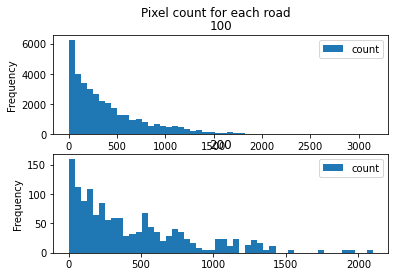

In [17]:
roads_stats_df.plot.hist(column=['count'], by='road_type', bins=50, title = 'Pixel count for each road')


In [18]:
roads_stats_filtered=roads_stats_df[roads_stats_df['count']>COUNT_THRESHOLD]


### Calcul et analyses des statistiques par types

In [19]:
# Create a table with the values of pixels on a road
# cf https://gis.stackexchange.com/questions/260304/extract-raster-values-within-shapefile-with-pygeoprocessing-or-gdal

pixel_values=pd.DataFrame()

for tile_idx in tqdm(tiles_info_reproj.index, desc='Getting pixel values'):

    roads_on_tile=clipped_roads[clipped_roads['tile']==tiles_info_reproj.loc[tile_idx,'title']]
    dataset = tiles_info_reproj.loc[tile_idx,'filepath']

    for cover_type in roads_on_tile['BELAGSART'].unique().tolist():

        road_shapes=roads_on_tile[roads_on_tile['BELAGSART']==cover_type]

        # extract the geometry in GeoJSON format
        geoms = road_shapes.geometry.values # list of shapely geometries

        geoms = [mapping(geoms[0])]

        # extract the raster values values within the polygon 
        with rasterio.open(dataset) as src:
            out_image, out_transform = mask(src, geoms, crop=True)

        # no data values of the original raster
        no_data=src.nodata

        if no_data is None:
            no_data=0
            # print('The value of "no data" is set to 0 by default.')
        
        for band in BANDS:

            # extract the values of the masked array
            data = out_image[band-1]

            # extract the the valid values
            val = np.extract(data != no_data, data)

            d=pd.DataFrame({'pix_val':val, 'band_num': band, 'road_type': cover_type})

            pixel_values = pd.concat([pixel_values, d],ignore_index=True)


Getting pixel values: 100%|██████████| 3087/3087 [02:12<00:00, 23.29it/s]


In [44]:
pixels_per_band={'road_type':[], 'band1':[], 'band2':[], 'band3':[], 'band4':[]}

for cover_type in pixel_values['road_type'].unique().tolist():

    for band in BANDS:

        pixels_list=pixel_values.loc[(pixel_values['road_type']==cover_type) & (pixel_values['band_num']==band), ['pix_val']]['pix_val'].to_list()
        pixels_per_band[f'band{band}'].extend(pixels_list)

    # Following part to change. Probably, better handling of the no data would avoid this mistake
    max_pixels=max(len(pixels_per_band['band1']), len(pixels_per_band['band2']), len(pixels_per_band['band3']), len(pixels_per_band['band4']))

    for band in BANDS:
        len_pixels_serie=len(pixels_per_band[f'band{band}'])

        if len_pixels_serie!=max_pixels:

            fill=[no_data]*max_pixels
            pixels_per_band[f'band{band}'].extend(fill[len_pixels_serie:])

            print(f'{max_pixels-len_pixels_serie} pixels where missing on the band {band}. There where replaced with the value used of no data ({no_data})')


    pixels_per_band['road_type'].extend([cover_type]*len(pixels_list))

pixels_per_band=pd.DataFrame(pixels_per_band)

152 pixels where missing on the band 1. There where replaced with the value used of no data (0)
72 pixels where missing on the band 2. There where replaced with the value used of no data (0)
18 pixels where missing on the band 1. There where replaced with the value used of no data (0)
15 pixels where missing on the band 2. There where replaced with the value used of no data (0)


In [45]:
len(pixels_per_band['road_type'])

1572863

In [46]:
# Calculate the statistics of the pixel by band and by type of road cover

cover_stats={'cover':[], 'band':[], 'min':[], 'max':[], 'mean':[], 'median':[], 'std':[], 'count':[]}

for cover_type in pixel_values['road_type'].unique().tolist():

    for band in BANDS:
        pixels_subset=pixel_values[(pixel_values['band_num']==band) & (pixel_values['road_type']==cover_type)]

        cover_stats['cover'].append(cover_type)
        cover_stats['band'].append(band)
        cover_stats['min'].append(pixels_subset['pix_val'].min())
        cover_stats['max'].append(pixels_subset['pix_val'].max())
        print(pixels_subset['pix_val'].max())
        cover_stats['mean'].append(pixels_subset['pix_val'].mean())
        cover_stats['median'].append(pixels_subset['pix_val'].median())
        cover_stats['std'].append(pixels_subset['pix_val'].std())
        cover_stats['count'].append(pixels_subset['pix_val'].count())



255
255
255
255
255
255
255
255


In [47]:
print([x-256 for x in cover_stats['max']])


[-1, -1, -1, -1, -1, -1, -1, -1]


In [48]:
cover_stats['max']=[int(x) for x in cover_stats['max']] # Otherwise, the values get transformed to x-256 when converted in dataframe

cover_stats_df=pd.DataFrame(cover_stats)
cover_stats_df['mean']=cover_stats_df['mean'].round(1)
cover_stats_df['std']=cover_stats_df['std'].round(1)

print(cover_stats_df)

cover_stats_df.to_csv(STATS_TYPE)

   cover  band  min  max   mean  median   std    count
0    100     1    1  255   55.0    56.0  28.7  1464968
1    100     2    1  255   81.7    87.0  41.7  1465048
2    100     3    1  255   98.1   104.0  43.7  1465120
3    100     4    1  255   95.6   100.0  37.7  1465120
4    200     1    1  255   78.9    83.0  37.2   107725
5    200     2    3  255  116.4   116.0  67.8   107728
6    200     3    2  255  134.0   134.0  69.7   107743
7    200     4    1  255  122.3   121.0  61.8   107743


In [ ]:
'''# extract the row, columns of the valid values
import numpy as np
row, col = np.where(data != no_data) 
elev = np.extract(data != no_data, data)

d=pd.DataFrame({'elev':elev})

from rasterio import Affine # or from affine import Affine
T1 = out_transform * Affine.translation(0.5, 0.5) # reference the pixel centre
rc2xy = lambda r, c: (c, r) * T1

d = gpd.GeoDataFrame({'col':col,'row':row,'elev':elev})

# coordinate transformation
d['x'] = d.apply(lambda row: rc2xy(row.row,row.col)[0], axis=1)
d['y'] = d.apply(lambda row: rc2xy(row.row,row.col)[1], axis=1)

# geometry
from shapely.geometry import Point
d['geometry'] =d.apply(lambda row: Point(row['x'], row['y']), axis=1)

d.to_file(PROCESSED_FOLDER+'/shapefiles_gpkg/test_pixel_values.shp')'''

#### Boxplots

In [49]:
if not os.path.exists(os.path.join(FINAL_FOLDER, 'images')):
    os.mkdir(os.path.join(FINAL_FOLDER, 'images'))
    print('The final directory for images was created')

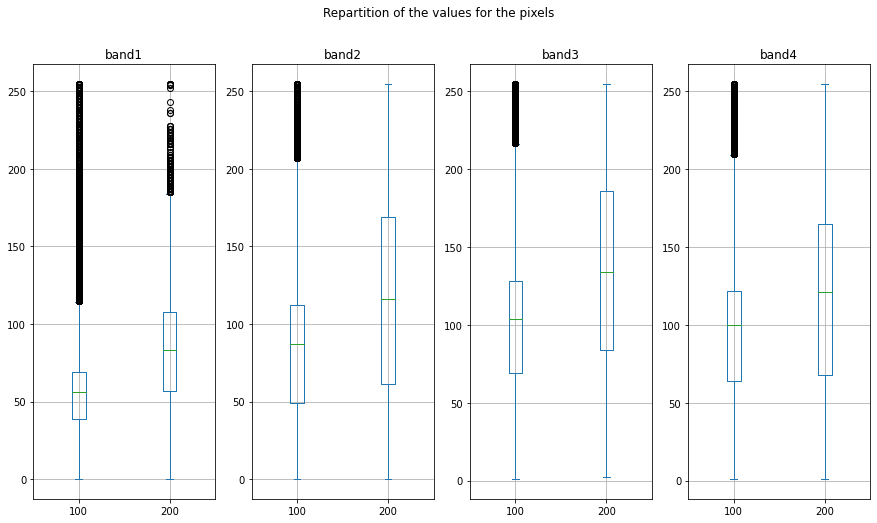

In [50]:
bp_pixel_bands=pixels_per_band.plot.box(by='road_type', title=f'Repartition of the values for the pixels', figsize=(15,8), grid=True)
fig = bp_pixel_bands[0].get_figure()
fig.savefig(os.path.join(FINAL_FOLDER, 'images/boxplot_pixel_in_bands.jpg'))

In [ ]:
# pixels_subset.plot.box(column='pix_val', by=['road_type','band_num'], figsize=(10,8))

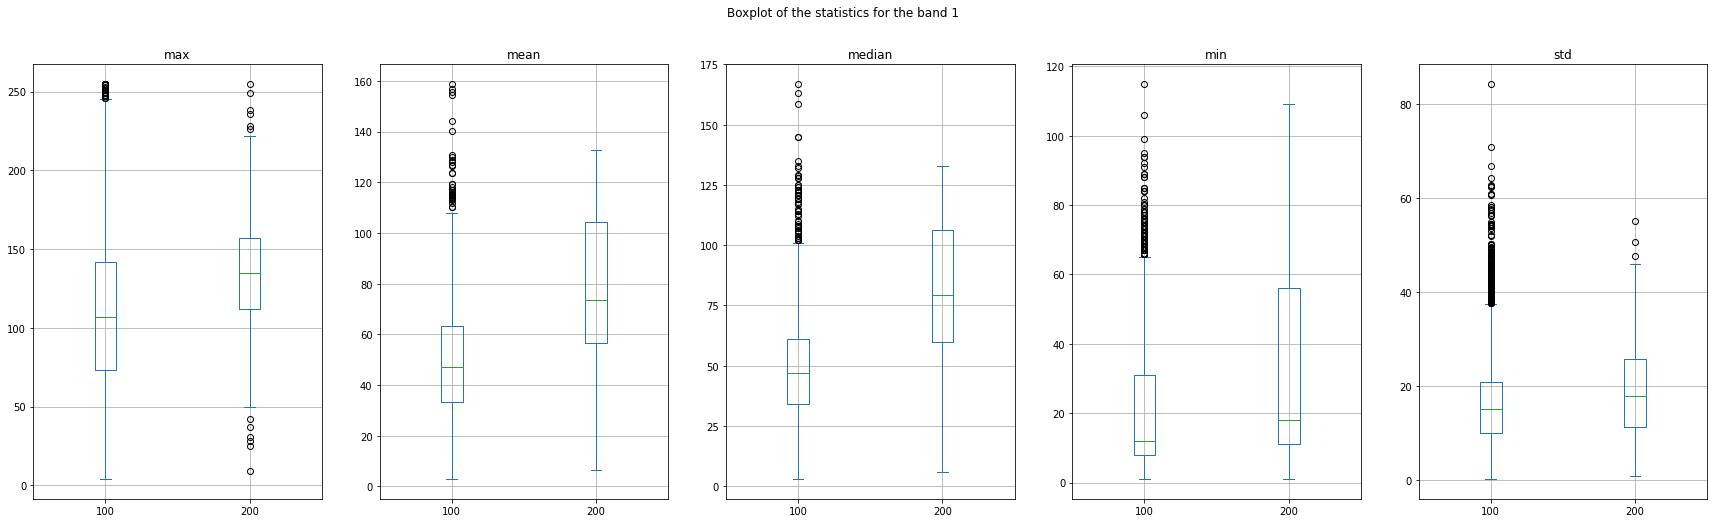

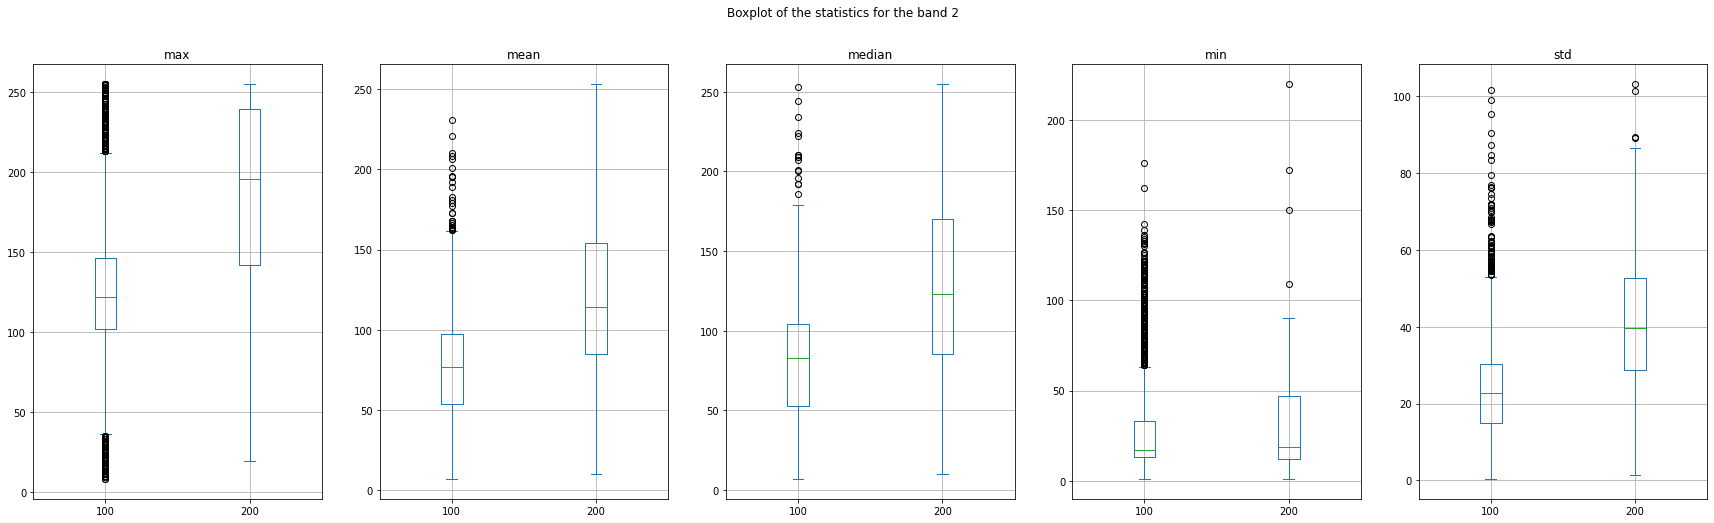

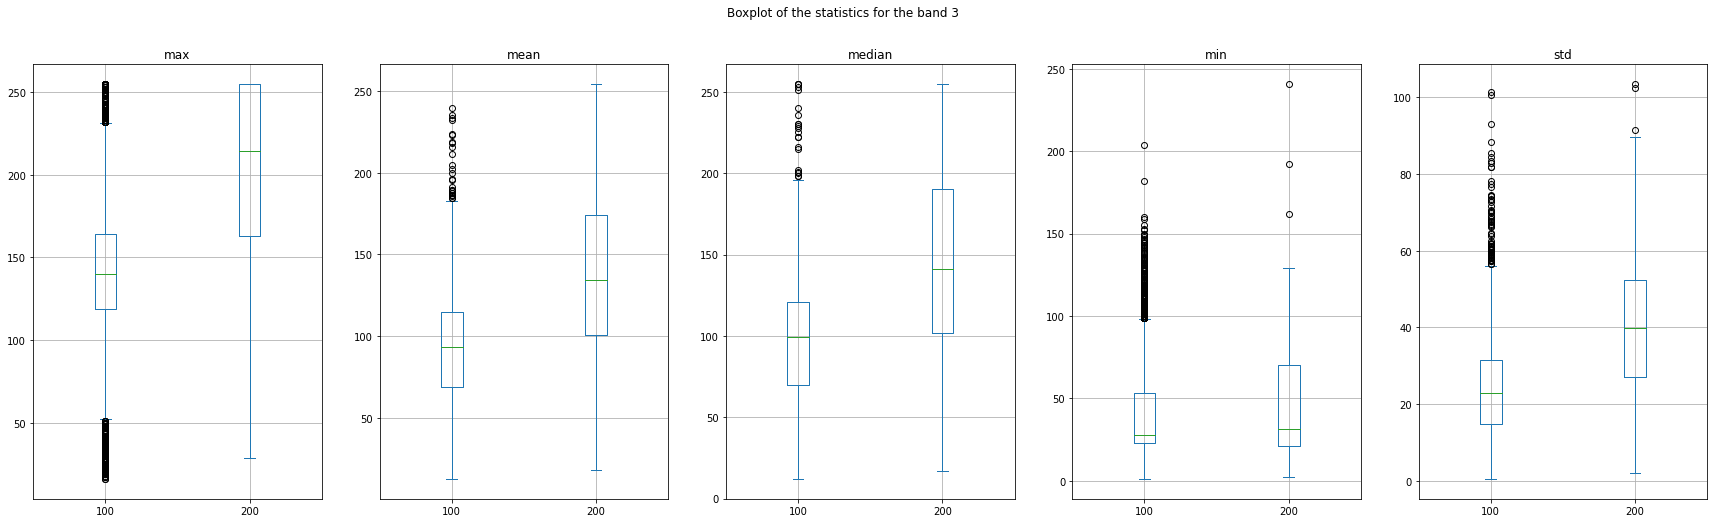

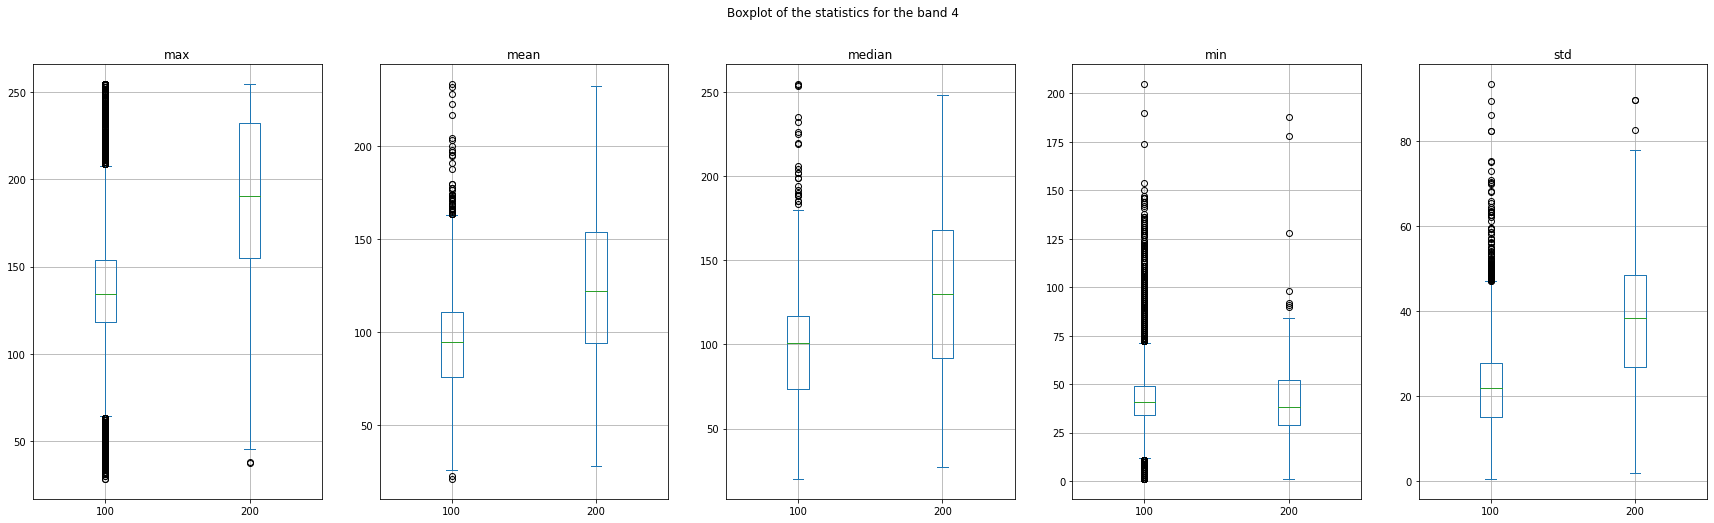

In [51]:
for band in BANDS:
    roads_stats_subset=roads_stats_filtered[roads_stats_filtered['band']==band].drop(columns=['count', 'band', 'road_id'])
    roads_stats_plot=roads_stats_subset.plot.box(by='road_type', figsize=(30,8), title=f'Boxplot of the statistics for the band {band}', grid=True)

    # roads_stats_subset.boxplot(by='road_type', figsize=(30,8))

    fig = roads_stats_plot[0].get_figure()
    fig.savefig(os.path.join(FINAL_FOLDER, f'images/boxplot_stats_band_{band}.jpg'))

#### PCA

Do the parameters (bands and stats) successfully explain/distinguish the type of road cover?
 
-> Are the clusters well defined?

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# cf. https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [53]:
print(pixels_per_band.head(5))
print(roads_stats_filtered.head(5))

   road_type  band1  band2  band3  band4
0        100    129     61     88     60
1        100    130     60     87     57
2        100     96    100    121    103
3        100    105     87    109     85
4        100     79    143    160    145
     min    max        mean  count        std  median  band  road_id  \
0   61.0  169.0   85.326774   1677  18.469671    77.0     1  20115.0   
1   34.0  151.0  126.478831   1677  29.762612   140.0     2  20115.0   
2   60.0  171.0  144.997018   1677  27.601679   157.0     3  20115.0   
3   42.0  152.0  128.268933   1677  28.531163   142.0     4  20115.0   
12  39.0  135.0   75.012048     83  14.968637    72.0     1  27632.0   

    road_type           tile_id  
0         100  68339, 46157, 17  
1         100  68339, 46157, 17  
2         100  68339, 46157, 17  
3         100  68339, 46157, 17  
12        100  68340, 46156, 17  


Analysis on the value of the pixels

In [54]:
features = ['band1', 'band2', 'band3', 'band3']

# Separating out the features
x = pixels_per_band.loc[:, features].values

# Separating out the target
y = pixels_per_band.loc[:,['road_type']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [63]:
pca = PCA(n_components=4)

coor_PC = pca.fit_transform(x)

coor_PC_df = pd.DataFrame(data = coor_PC, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
results_PCA = pd.concat([coor_PC_df, pixels_per_band[['road_type']]], axis = 1)


In [64]:
# results_PCA.to_csv(os.path.join(FINAL_FOLDER, 'tables/PCA_pixel_values.csv'))

In [70]:
expl_var_ratio=[round(x*100,2) for x in pca.explained_variance_ratio_.tolist()]

print(expl_var_ratio)

[77.23, 14.36, 8.41, 0.0]


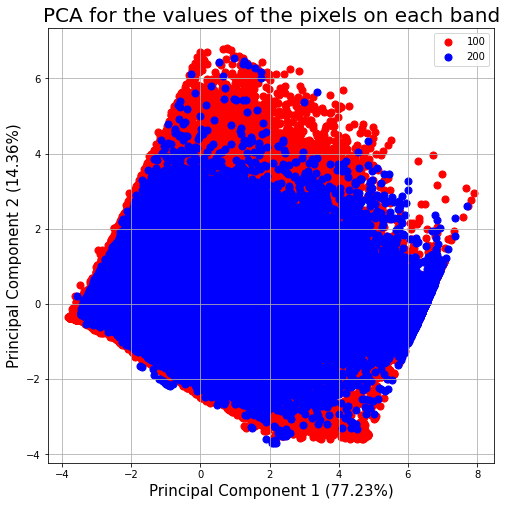

In [71]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component 1 ({expl_var_ratio[0]}%)', fontsize = 15)
ax.set_ylabel(f'Principal Component 2 ({expl_var_ratio[1]}%)', fontsize = 15)
ax.set_title('PCA for the values of the pixels on each band', fontsize = 20)

targets = [100, 200]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = results_PCA['road_type'] == target
    ax.scatter(results_PCA.loc[indicesToKeep, 'PC1']
               , results_PCA.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# fig.savefig(os.path.join(FINAL_FOLDER, 'images/PCA_pixels_PC12.jpg'))

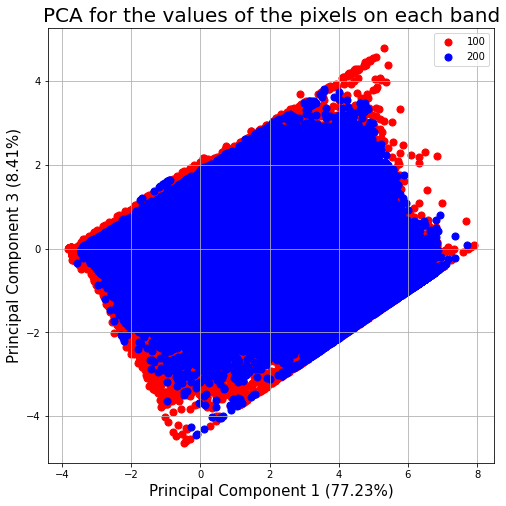

In [72]:
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component 1 ({expl_var_ratio[0]}%)', fontsize = 15)
ax.set_ylabel(f'Principal Component 3 ({expl_var_ratio[2]}%)', fontsize = 15)
ax.set_title('PCA for the values of the pixels on each band', fontsize = 20)

targets = [100, 200]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = results_PCA['road_type'] == target
    ax.scatter(results_PCA.loc[indicesToKeep, 'PC1']
               , results_PCA.loc[indicesToKeep, 'PC3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# fig.savefig(os.path.join(FINAL_FOLDER, 'images/PCA_pixels_PC13.jpg'))

In [73]:
pca.explained_variance_

# https://www.mohanwugupta.com/post/broken_stick/


array([3.08918057e+00, 5.74418475e-01, 3.36403496e-01, 3.77948208e-32])